In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir

exp_path = '../experiments'

low_psi_path = exp_path + '/20240603-094206-RDK_n10_psi_0.001'
low_psi = float(low_psi_path.split('_')[-1])

high_psi_path = exp_path + '/20240603-094003-RDK_n10_psi_0.01'  # TODO change these paths when have 0.75 results and have chosen a low psi
high_psi = float(high_psi_path.split('_')[-1])

# Runtime analysis

In [24]:
runtimes_low_psi = pd.read_csv(low_psi_path + '/epoch_runtimes.csv')
runtimes_low_psi['Psi'] = low_psi
runtimes_low_psi['cumtime'] = runtimes_low_psi['runtime'].cumsum()

runtimes_high_psi = pd.read_csv(high_psi_path + '/epoch_runtimes.csv')
runtimes_high_psi['Psi'] = high_psi
runtimes_high_psi['cumtime'] = runtimes_high_psi['runtime'].cumsum()

runtimes = pd.concat([runtimes_low_psi, runtimes_high_psi])
runtimes

,epoch,runtime,Psi,cumtime
0,1,109.516126,0.001,109.516126
1,2,110.631576,0.001,220.147702
2,3,109.881363,0.001,330.029065
3,4,110.267514,0.001,440.296579
4,5,110.295520,0.001,550.592099
...,...,...,...,...
40,41,121.601060,0.010,4934.923668
41,42,120.301710,0.010,5055.225379
42,43,119.486390,0.010,5174.711769
43,44,119.350896,0.010,5294.062665


Text(0.5, 1.0, 'Cumulative Training Time Per-Epoch')

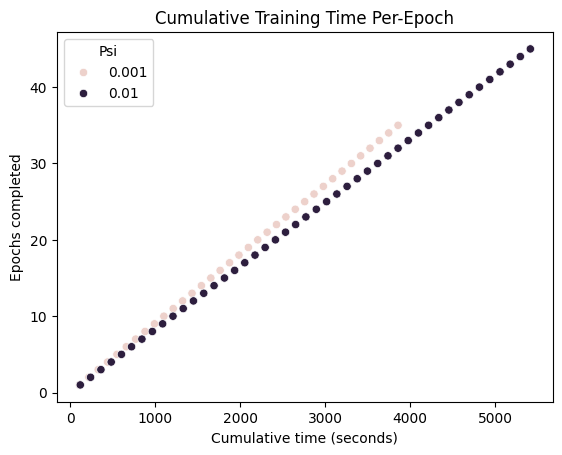

In [20]:
sns.scatterplot(runtimes, x='cumtime', y='epoch', hue='Psi')
plt.xlabel('Cumulative time (seconds)')
plt.ylabel('Epochs completed')
plt.title('Cumulative Training Time Per-Epoch')

# PPSE Performance per epoch

In [72]:
polySE_low_psi = []
for loc in listdir(low_psi_path):
    if loc.startswith('checkpoint'):
        epoch = int(loc.split('_')[-1]) + 1
        res = pd.read_csv(f'{low_psi_path}/{loc}/polySE_results_aggregations.csv')
        res['epoch'] = epoch
        res['Psi'] = low_psi
        polySE_low_psi.append(res)
polySE_low_psi = pd.concat(polySE_low_psi)

polySE_high_psi = []
for loc in listdir(high_psi_path):
    if loc.startswith('checkpoint'):
        epoch = int(loc.split('_')[-1]) + 1
        res = pd.read_csv(f'{high_psi_path}/{loc}/polySE_results_aggregations.csv')
        res['epoch'] = epoch
        res['Psi'] = high_psi
        polySE_high_psi.append(res)
polySE_high_psi = pd.concat(polySE_high_psi)
polySE = pd.concat([polySE_high_psi, polySE_low_psi])

groupby_cols = ['epoch', 'Psi']

warm_start = polySE.query('fake_triple_component != "both"')
warm_medians = []
for tup, subdf in warm_start.groupby(groupby_cols):
    warm_medians.append(list(tup) + [subdf.AUPRC.median()])
warm_medians = pd.DataFrame(warm_medians, columns=groupby_cols + ['median_AUPRC']).sort_values('epoch')
warm_medians['rolling_max'] = None
for psi in warm_medians.Psi.unique():
    cummax = warm_medians.query(f'Psi == {psi}').median_AUPRC.cummax()
    warm_medians['rolling_max'].loc[cummax.index] = cummax.values

cold_start = polySE.query('fake_triple_component == "both"')
cold_medians = []
for tup, subdf in cold_start.groupby(groupby_cols):
    cold_medians.append(list(tup) + [subdf.AUPRC.median()])
cold_medians = pd.DataFrame(cold_medians, columns=groupby_cols + ['median_AUPRC']).sort_values('epoch')
cold_medians['rolling_max'] = None
for psi in cold_medians.Psi.unique():
    cummax = cold_medians.query(f'Psi == {psi}').median_AUPRC.cummax()
    cold_medians['rolling_max'].loc[cummax.index] = cummax.values

/var/folders/_x/2pk9s5z166x9c0h399wmby_h0000gp/T/ipykernel_62056/56395436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  warm_medians['rolling_max'].loc[cummax.index] = cummax.values
/var/folders/_x/2pk9s5z166x9c0h399wmby_h0000gp/T/ipykernel_62056/56395436.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  warm_medians['rolling_max'].loc[cummax.index] = cummax.values
/var/folders/_x/2pk9s5z166x9c0h399wmby_h0000gp/T/ipykernel_62056/56395436.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

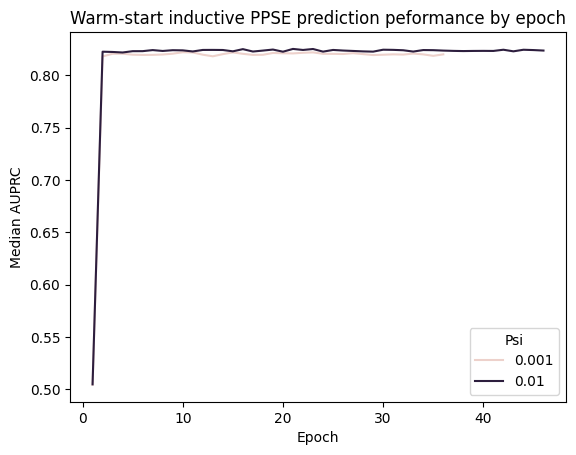

In [79]:
sns.lineplot(warm_medians, x='epoch', y='median_AUPRC', hue='Psi')
plt.xlabel('Epoch')
plt.ylabel('Median AUPRC')
plt.title('Warm-start inductive PPSE prediction peformance by epoch')
plt.savefig('AUPRC_by_epoch_warm_start.png')

Text(0.5, 1.0, 'Warm-start inductive PPSE prediction peformance by epoch')

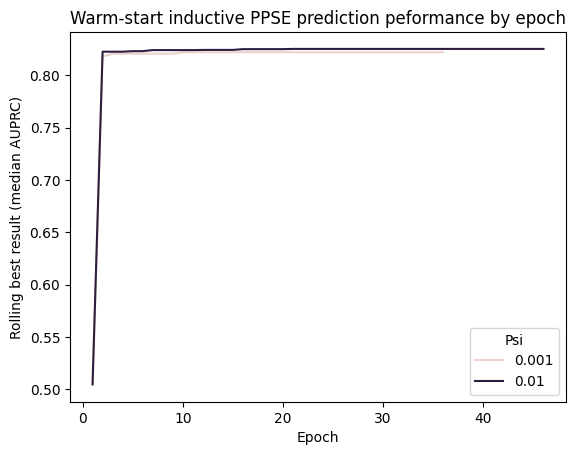

In [78]:
sns.lineplot(warm_medians, x='epoch', y='rolling_max', hue='Psi')
plt.xlabel('Epoch')
plt.ylabel('Rolling best result (median AUPRC)')
plt.title('Warm-start inductive PPSE prediction peformance by epoch')

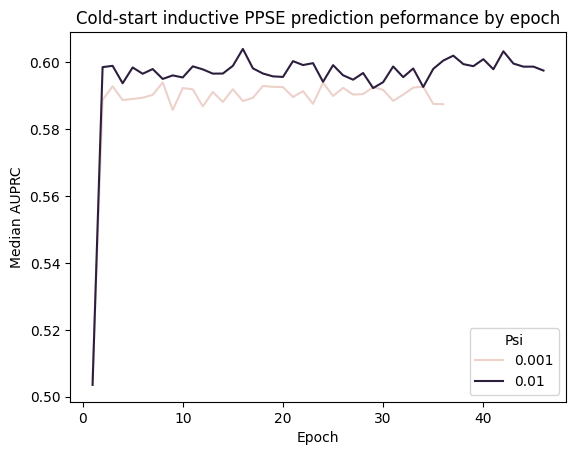

In [80]:
sns.lineplot(cold_medians, x='epoch', y='median_AUPRC', hue='Psi')
plt.xlabel('Epoch')
plt.ylabel('Median AUPRC')
plt.title('Cold-start inductive PPSE prediction peformance by epoch')
plt.savefig('AUPRC_by_epoch_cold_start.png')

Text(0.5, 1.0, 'Cold-start inductive PPSE prediction peformance by epoch')

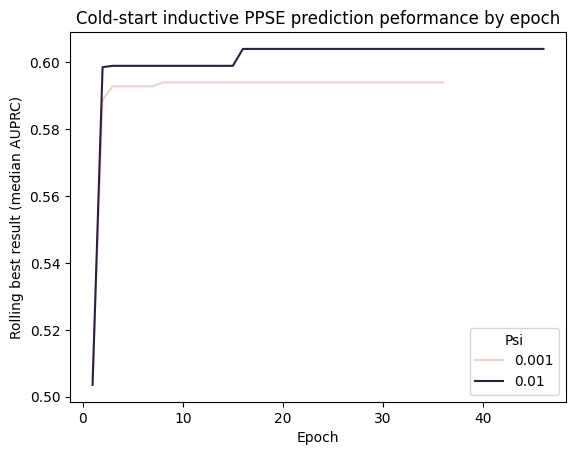

In [77]:
sns.lineplot(cold_medians, x='epoch', y='rolling_max', hue='Psi')
plt.xlabel('Epoch')
plt.ylabel('Rolling best result (median AUPRC)')
plt.title('Cold-start inductive PPSE prediction peformance by epoch')